<a href="https://colab.research.google.com/github/gilzeevi25/STTM/blob/main/CyberSecAI_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cyber Security and AI
# Short Text Predator Detection and Model Watermarking

By:
 - Gil Zeevi 203909320
 - Joel Liurner 346243579
 - Alon Hartanu 305143422


#<u>Abstract</u> - Quick summary of work
In this paper and the attached notebooks we inspect several methods and models in order to build a classifier that distinguishes if a chat conversations is of malicious nature. Our goal was to create a very sharp model that can "read" a full chat conversation and detect if one of the participants is a sexual predator. We based the solution on a well known predator conversation dataset PAN-12 and inspected different models such as BERT transformers, SVM, DeepNN and Ensemble models. In the end we concluded that using a two-stages classification, as the first stage is engaging voting classifier on-premise and the second is to send all benign classified conversations into the cloud on second inspection with RoBERTa.<br>
Furthermore, we inspected some strategies in order to watermark the model so that it could be deployable on mobile devices and prove ownership if it were to be stolen. we then implemented a recent paper that suggests robust watermarks based on inverse document frequency.

**Paper and code are also available on our github repository:<br>**
https://github.com/gilzeevi25/STTM

# Problem formulation

#### Predator detection

The following starting point was given:

1. A "labeled" dataset of 56 chat conversations with predators from [Perverted Justice website](http://www.perverted-justice.com/). These were provided in XML format, with several inconsistencies. 
2. Although these conversations were labeled, they were all positive, so we did not have harmless conversations with "negative" label to train the models and evaluate our decisions.
3. The client would like to implement the algorithm in a chat framework, where there are no restrictions when a user wants to contact another one, and the details they provide are not verified (such as the age, location, interests). The model to be built cannot rely on this data provided, rather needs to be on the content of the conversations and behaviour of the participants.
4. The specific need on building a system that could classify a conversation on the parameter of whether one of the participants was a predator or not. 

Our purpose was to get to an algorithm with highly precise results so that for every conversation the algorithm would "read", it would predict accurately if it was a perverted conversation from a predator. Due to the relevance of the topic, and how harmful it could be to young children, we proposed that the accuracy should be higher than 98%.<br>

another challenge we are dealing with is respone time. we would like that our model, at inference stage, would perform as quick as possible, hence should be executed on-premise.<br>

Furthermore, we are dealing with very limited resources, as we are a small group who would like to build a POC model, and as such we dont have access to many GPU resources and our RAM is also limited.<br>



#### Model Watermarking

As it is shown during the report, our STTM is a success and has high accuracy and True Positive Rate with controlled FPR. Due to the criticity of the topic, the model is deployed in each mobile app as descentralized to ensure low response time. 

Then, as the model would be exposed and accessible, we needed to come up with a solution to watermark it, so that if stolen we could prove it by copyright protection. 

The solution should not affect the model performance, and consider aspects of simplicity, robustness and security.

# Data Handling

### Perverted Justice Dataset

Initially we had to work with the proposed dataset of 56 conversations of different predators. The starting challenge was to be able to parse and read the conversation as the provided XML was not correctly constructed. To do so, we build a parser that could:
- Open each conversation file.
- Remove and ignore the initial information about the users such as location and age, as it is not trustworthy and we would no base the decisions on it.
- Find each conversation line and comment, assign it to the user who sent it.
- Escape malformed and unsecaped characters on each line.
- Write back to another XML file to be able to parse all of them on a pandas Dataframe.

### PAN12 Dataset

#### Introduction

In order to achieve the proposed high accuracy, we agreed that we would need benign conversations as well as enlarging considerably the dataset. That is why we dedicated time to research alternatives to enlarge the sample and dataset. 


We got to know that this topic was not new, rather it was a moral concern for several years. While traveling through the internet, we've discovered that getting access to this kind of data, is not an easy task as these chat conversations are strictly protected by privacy rules.<br>
Finally, we've found out that In the 2012, on the conferenced organized by [PAN](https://pan.webis.de/), in the framework of [CLEF Initiative](https://www.clef-initiative.eu/), there was a shared task called "Sexual Predator Identification" and was based on a dataset that we will call from now on PAN12. 

PAN is a series of scientific events and shared tasks on digital text forensics and stylometry.

The CLEF Initiative (Conference and Labs of the Evaluation Forum, formerly known as Cross-Language Evaluation Forum) is a self-organized body whose main mission is to promote research, innovation, and development of information access systems with an emphasis on multilingual information.

We asked for access to PAN12 and we were granted. We now have in our hands a Sexual predator chat conversation dataset that includes more than 66000 conversations training corpus with thousands of them being malicious.

#### Exploratory Data Analysis on the datasets

The PAN12 Dataset is a huge dataset which most of the samples are benign, as we would suppose real data on the chat room would look like.<br>
We can tell how severly our data is imbalanced and so our classifier may get biased towards the prediction.<br>
In cases when the data is highly imbalanced, it is better to look also on F1 score, which is  denoted as the harmonic mean of precision and recall.


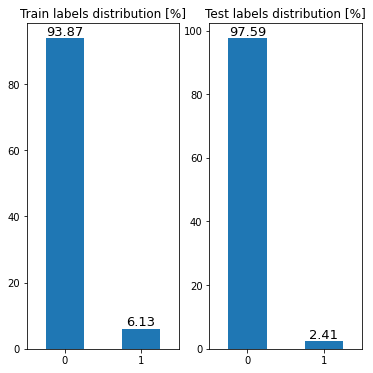

We can also analyze the length of a conversation in rows (or chats) and see how it compares between PAN12 and PJ corpus. distribution shape looks same, however, PJ conversations are much longer as they are filtered and selected for the purpose. PAN12 will have many conversations of predators trying to engange and approach with inocent people, without succeeding in many cases.

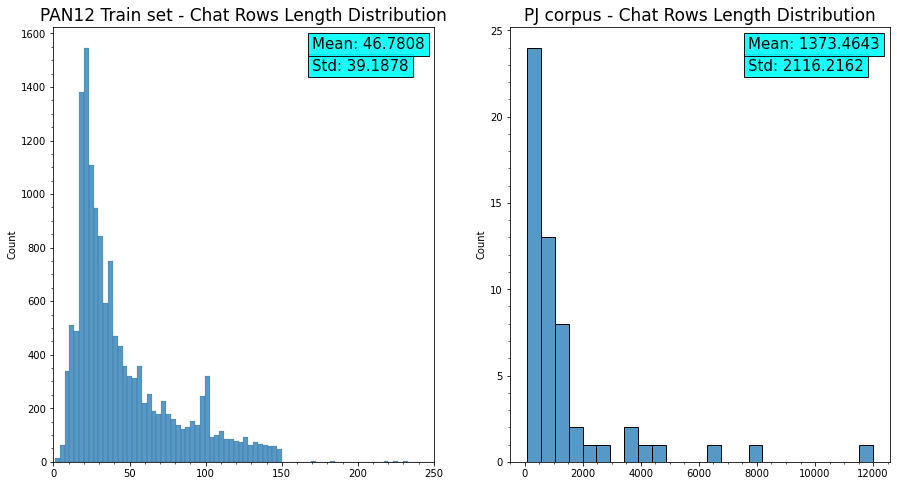

It is possible to visualize the most common words in malicious conversations from PAN12 train set. We can observe that relevant words such as "lol", "want" and "know" might be relevant to characterize this conversations.

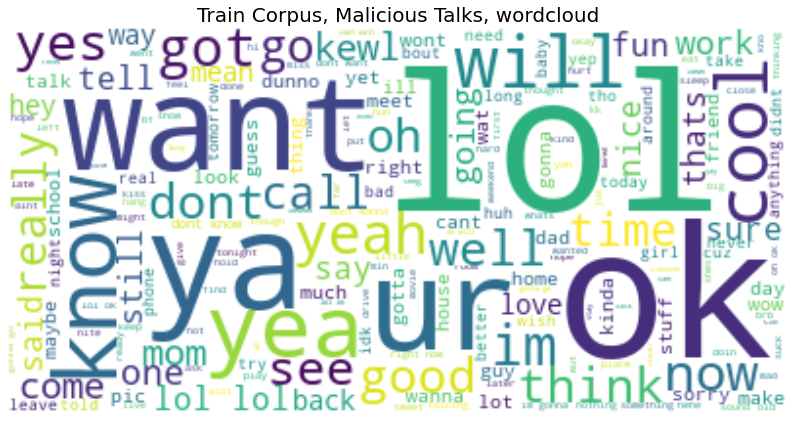

When comparing to PJ corpus, we observe that same words are relevant. It is even intersting to notice that -although not extremly used and the most frequent-  words like "pic" appear in both corpus and might be relevant to classify.

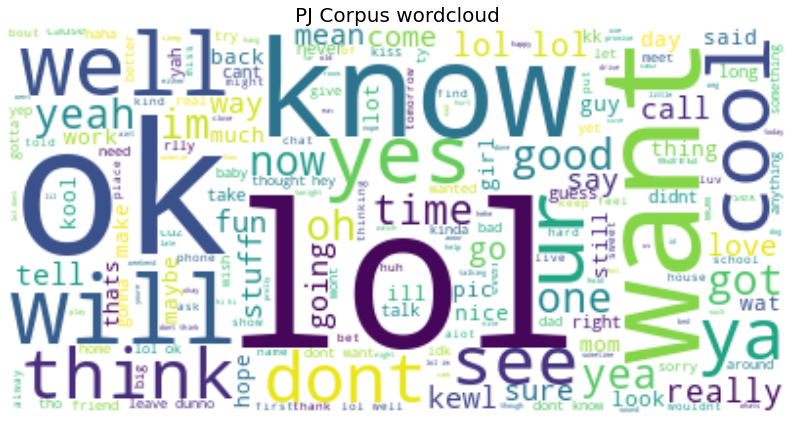

Inspecting the wordcloud of both corpuses/corpora, ignites a feeling that maybe somehow the good old TF-IDF might be really really useful here.

#### PAN12 Pre-Processing

As it happens with any large corpus, there is some preprocessing needed to get the most out of it. We performed the following cleaning and filtering actions onf the dataset:

- Filter conversations with only one participant
- Filter extremely short conversations, where users did not participate with more than 6 sentences
- Remove conversations with long sequences of unrecognized characters as they will be hard to classify and would not contribute to the models.

The dataset itself is split into training and testing dataset. After such data processing, we can start the modelling with:

**Training data**
- Num of Conv: 14703
- Num of suspicious conv: 901
- Num predators: 137

**Testing Data**
- Num of Conv: 155128
- Num of suspicious conv: 3737
- Num predators: 254

One of the most unique things in pan12 dataset is that the testing is X10 bigger than training, and as such it can also help measure an `inference` time where it is measured how quick a trained model respond to many conversations.

#### EDA focusing on users inside a chat conversation

PAN12 Train set - Predators Chat Rows Length description:
```
       labels      length
count   901.0  901.000000
mean      1.0   41.859046
std       0.0   49.725526
min       1.0    1.000000
25%       1.0   15.000000
50%       1.0   32.000000
75%       1.0   53.000000
max       1.0  730.000000
```
PJ corpus - Predators Chat Rows Length description:
```
       labels       length
count    56.0    56.000000
mean      1.0   641.767857
std       0.0   900.360170
min       1.0    33.000000
25%       1.0   150.750000
50%       1.0   379.000000
75%       1.0   613.750000
max       1.0  4624.000000
```
PAN12 Train set - VIctims Chat Rows Length description:
```
       labels      length
count   907.0  907.000000
mean      0.0   40.466373
std       0.0   41.265384
min       0.0    1.000000
25%       0.0   15.000000
50%       0.0   33.000000
75%       0.0   52.000000
max       0.0  430.000000
```
PJ corpus - VIctims Chat Rows Length description:
```
       labels       length
count    56.0    56.000000
mean      0.0   731.696429
std       0.0  1260.225852
min       0.0    47.000000
25%       0.0   155.250000
50%       0.0   328.500000
75%       0.0   598.000000
max       0.0  7381.000000
```

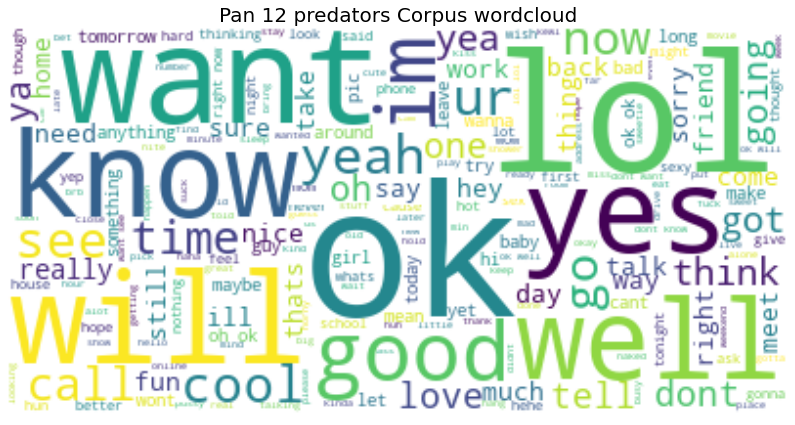

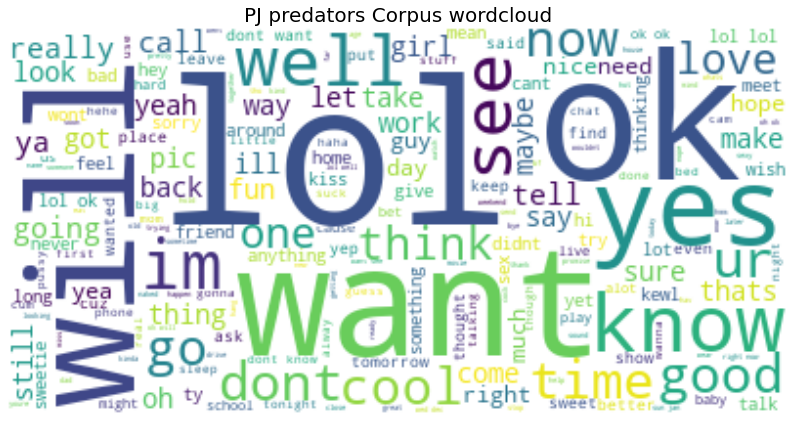

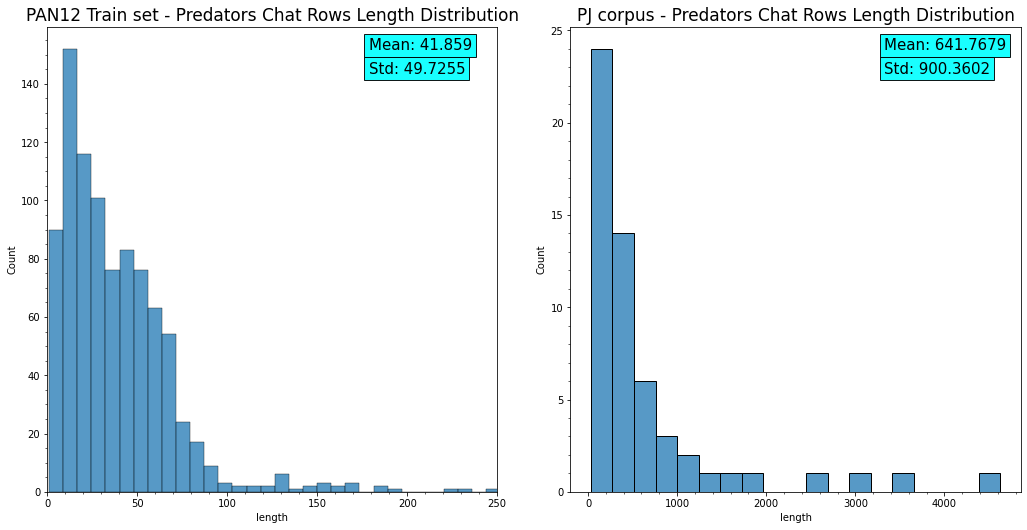

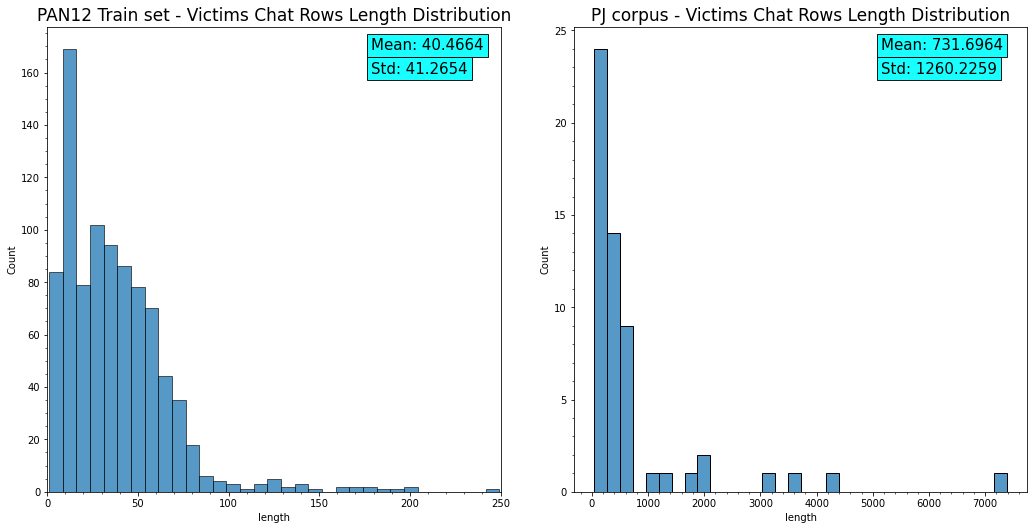

# Research and implemented algorithms

Once we had the full corpus, we would implement different algorithms to ensure the best results. To train and evaluate them, we created 3 datasets which we called: *X_train* (from PAN12 training dataset), *X_test* (from PAN12 testing set) and *X_test_pj* (the provided dataset from perverted justice). 

To all of them we applied the technique Bag of Words with TF-IDF weighting.

What we can prove with this split is to be able to train and test an algorithm with PAN12 dataset, and then evaluate it with the given Perverted Justice. We would desire that the evaluation on the 56 Perverted Justice conversations were labeled as True.

We evaluated the results with accuracy, F1 score, AUC , 0.1% & 1% FPR Detection rate, and running time of test set evaluation.<br>
Measuring the inference time on test is useful here as it is X10 bigger than train, thus can explain how quick the model predicts big traffic of chat conversations.

### XGBoost Classifier

To start with, trained the model with a generic library from XGBoost and got surprisingly good results.

```
model_xgb = xgboost.XGBClassifier(eval_metric='logloss',use_label_encoder=False)

Accuracy on PAN12 test dataset:  98.52702284565005
F1_Score on PAN12 test dataset:  60.61023961385968
Accuracy on PJ test dataset:  96.42857142857143
```

After training the model, this gradient boosting classifier is highly accurate on PAN12 testing data, and surprisingly good<br>  (96+ %, 54/56 classified as `True`) with Perverted Justice (PJ) dataset. We can put here our baseline to improve and get to the desired results.

### Light GBM Classifier

LightGBM is a Gradient Boosting library created by Microsoft. We applied its classifier to our datasets and got the following results:

```
modelgbm = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)

Accuracy on PAN12 test dataset:  98.57794853282451
F1_Score on PAN12 test dataset:  61.6214335421016
Accuracy on PJ test dataset:  98.21428571428571
```

This is a clear improvement and already getting to the 98+ % on PAN12 and PJ datasets.

### SVM Classifier

According to several papers (we mostly based on Javier Parapar and Barreiro 2012; Esa Villatoro-Tello and Villaseor-Pineda 2012; Morris and Hirst 2012; Meyer 2015), it has been proven that a Support Vector Machine classifier performs well when dealing with predator conversations. It is helpful to classify not only between malicious and benign conversations, but also to detect who is the predator in the conversation.


```
model_linear = LinearSVC(random_state=0, C=2.9, loss='squared_hinge', dual=True)

Accuracy on PAN12 test dataset:  98.51026249290908
F1_Score on PAN12 test dataset:  64.88441578864601
Accuracy on PJ test dataset:  98.21428571428571
```

We can observe that with this model and configuration, we get almost same accuracy on PAN12 test set, as well as achieve the 98+ % on PJ test set .  
The major downside of LinearSVC implementation throughout Scikit-learn module is that predict_proba function is not implemented. there are several workarounds for that, and we present the alternatives for this model.

#### Improving the SVM model and results

There were 3 attemps to improve the SVM based also on the Light GBM which yields great accuracy, here are the description and results:
<br>

**Adding C vector support to consider penalization for mis-classified samples**
```
model_svc = svm.SVC(kernel='linear', C=1, gamma='auto', random_state=0,probability=True)

Accuracy on PAN12 test dataset:  98.56054355113197
Accuracy on PJ test dataset:  96.42857142857143
```

**Perform Voting Classifier with linear LightGBM Classifier and SVM Classifier**
```
eclf = VotingClassifier(estimators=[('linear', lgb.LGBMClassifier
              (learning_rate=0.09,max_depth=-5,random_state=42)), 
              ('svc', svm.SVC(kernel='linear', C=1, gamma='auto', 
              random_state=0,probability=True)),]), voting='soft', 
              weights=[1, 1]) 

Accuracy on PAN12 test dataset:  98.63338662266
F1_Score on PAN12 test dataset:  64.52476572958501
Accuracy on PJ test dataset:  98.21428571428571

```

**Perform Stacking Classifier with linear LightGBM Classifier, SVC Classifier, and Linear SVC**
```
estimators = [
    ('sv,', svm.SVC(kernel='linear', C=1, gamma='auto', random_state=0,probability=True)),
     ('svtwo', LinearSVC(random_state=0, C=2.9, loss='squared_hinge', dual=True)),
     ('xgb',xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False)),
      ('linear', lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42))]
clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression())

Accuracy on PAN12 test dataset:  98.53798153782682
F1_Score on PAN12 test dataset:  65.23605150214593
Accuracy on PJ test dataset:  98.21428571428571
```

Some of the improvements did not work, however, the combination for the Voting Classifier with LightGBM and SVM Classifier has the best results.

It is important to note that a 98.2% accuracy on PJ dataset (as testing dataset) means we are classifying correctly 55 out of 56 conversations. We will continue to explore other alternatives to check consistency and if it can be improved.

### Classifier with Deep Neural Networks

In order to validate the results and also evaluate the relevance of this classifying tasks with Deep Neural Networks, we constructed the following architecture based on Tensorflow: 5 ReLu activation layers with Dropout and a final Sigmoid activation. The loss was computed with binary crossentropy formula and we used an "Adam" optimizer. 

```
model = Sequential()
    model.add(Dense(256, input_dim=121394, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy', metrics=['accuracy'])
```

The results were similar to the previous but not better in terms of accuracy, but F1 actually increased:
```
Accuracy on PAN12 test dataset:  98.04290650301687
F1_Score on PAN12 test dataset:  65.41353383458647
Accuracy on PJ test dataset:  98.21428571428571
```

### RoBERTa Classifier

We then changed the strategy to try to understand how does word embedding and transformers reacts and deals with predator conversations classification. We know that putting these models into production  will require many resources and will be expensive on one hand, but on the other hand, they suspect that they are well suited for these kind of tasks.

The RoBERTa Classifier (from Facebook RoBERTa model) proved to yield the most relevant results. 
From its pytorch official site: "*RoBERTa builds on BERT’s language masking strategy and modifies key hyperparameters in BERT, including removing BERT’s next-sentence pretraining objective, and training with much larger mini-batches and learning rates. RoBERTa was also trained on an order of magnitude more data than BERT, for a longer amount of time. This allows RoBERTa representations to generalize even better to downstream tasks compared to BERT.*"

The model was constructed with the following parameters, and considering that each conversation is not a short sentence, we used the technique of sliding window to move accross all conversation and take the mean of the segment representations.

```
model = finetune.Classifier(base_model=RoBERTa,chunk_long_sequences=True, n_epochs=1)
model.fit(train_corpus, train_labels)

Accuracy on PAN12 test dataset: 98.12
F1_Score on PAN12 test dataset:  63.16454097739614
Accuracy on PJ test dataset: 100.0
```

Although we chose only one epoch for training, it tooked 1hs and 45 minutes to complete. And despite of reducing slightly the Accuracy on test PAN12, we can observe a 100% accuracy when evaluating with PJ dataset.

#### textCNN Classifier

In order to compare to an embedding alternative, we run textCNN  which was offered in 2014 by Yoon Kim [arxiv](https://arxiv.org/abs/1408.5882)
textCNN model is actually convolutional neural networks (CNN) trained on top of pre-trained word vectors for sentence-level classification tasks. it is lighter than transformers (at inference stage it ran 3 time faster than RoBERTa) and more sophisticated than a simple DNN but on the other hand it doesnt rely on attention mechanism which might negatively affect the classification results.
```
model = ft.Classifier(base_model=TextCNN,chunk_long_sequences=True, n_epochs=3) 

Accuracy on PAN12 test dataset:  98.14
F1_Score on PAN12 test dataset:  63.17403526705853
Accuracy on PJ test dataset:  100.00
```

Training was done in 2 minutes(on A100 GPU) which is great and yielded results are surprising, as good and the other language model based on RoBERTa.

# Results Summary

We have taken an simple approach in order to train various classifiers based on different algorithms. Here a summary of the results for each model.

|metric|LightGBM|XGBoost|SVM|Voting|Stacking|DNN|RoBerta|TextCNN|
|---|---|---|---|---|---|---|---|---|
|***Accuracy on PAN12 test***|98\.58|98\.53|98\.56|**98\.63**|98\.54|98\.04|98\.12|98\.14|
|***F1\_Score***|61\.62|60\.61|64\.88|64\.52|65\.24|**65\.41**|63\.16|63\.17|
|***AUC***|92\.86|94\.62|96\.96|96\.6|97\.01|97\.72|**98\.01**|97\.5|
|***0\.1% FPR Detection***|44\.45|41\.96|38\.37|44\.93|38\.05|42\.57|39\.44|**52\.02**|
|***1% FPR Detection***|61\.17|58\.98|70\.22|69\.01|69\.23|**72\.73**|64\.76|65\.16|
|***Inference Time \[Min]***|**0\.03**|0\.04|1\.07|1\.07|1\.1|0\.2|53\.52|28\.55|
|***PervJust Accuracy***|98\.21|96\.43|96\.43|98\.21|98\.21|98\.21|**100\.0**|**100\.0**|

We observe that all models are good and predict pretty well test set with 95+ or even 98+ % accuracy. When validated against the 56 malicious conversations, also all of the models classify most of them as predators, which is the expected.

Given those results, we should stick to RoBERTa/textCNN and/or Voting Classifier with linear LightGBM and SVM Classifiers, depending if we would like to maximize testing with PAN12 or validation with PJ. If one were to be chosen, our trained RoBERTa is the natural candidate. nevertheless, our main goal is to engage this model on edge device, with very limited resourses to begin with, so choosing this heavy model will force us to collect chats, stack them over inside a queue on cloud and start classifying one by one when the average inference time for a given conversation is almost 1 minute. this whole operation might yield in a long response time, so when engaging a POC with light budget, it might not be a good idea to start with this kind of operation and rather stick to a classical ML model.

***We will pick Voting Classifier*** as our winning model to implement on edge devices. It has pretty decent accuracy and AUC scores, but more importantly its FP rate is smaller than Stacking classifier, which is important for the two-stages upfront.<br>
our business model consists of two main stages:
1. <u>first stage</u>: convincing a potential costumer/investor to invest in us, with engaging voting classifer on-premise ,as it is lightweight in terms of storage memory, and inference time, and has great overall results, even in the Deep Learning era.<br>
2. <u>second stage</u>:
after we get the moral and financal support of our investors, we will present an upgraded model which we call<br>
 `0-FN-POLICY` model, which we will explain about on the next paragraph.


We can inspect further by plotting and visualizing results. Our Voting Classifier has a quite impressive confusion matrix and a really good Area Under the Curve when plotting True Positive Rate against FPR (96.6%). 

It is worth mentioning that achieved models have a very low chance of not classifying as malicious a real predator, as well as incorrectly labeling a benign conversation as if it had a predator.

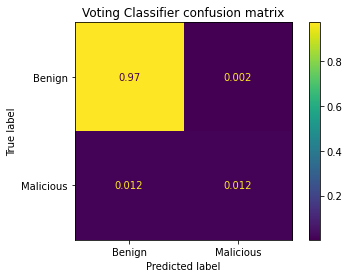

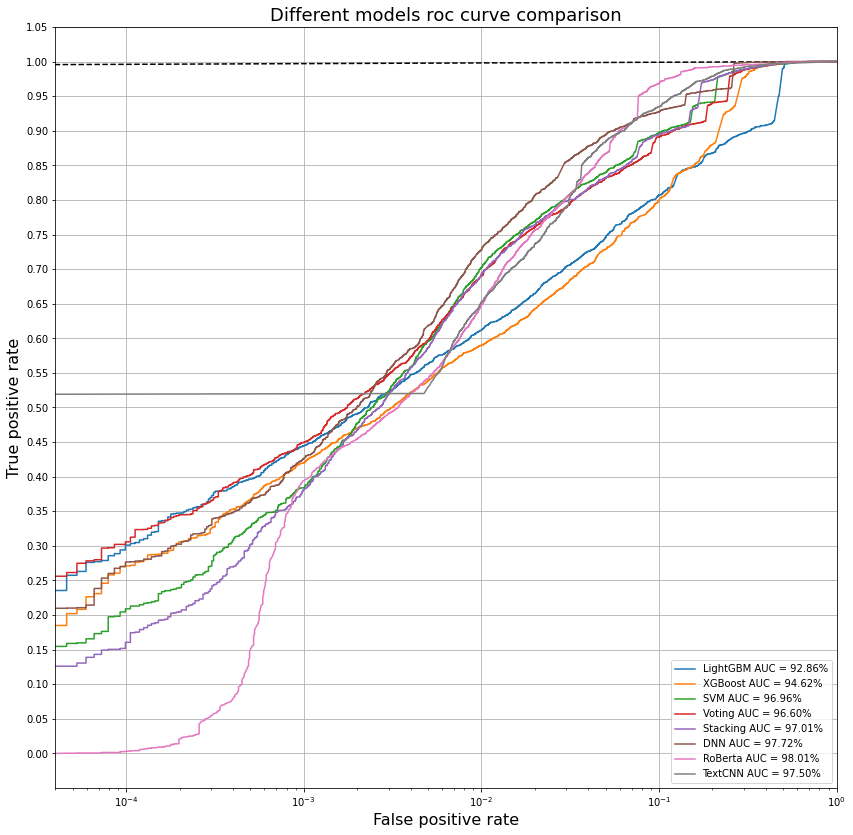

Most of the curves are quite similar, possibly DeepNN classifier has slightly higher AUC. However, altough RoBERTa curve has a different behaviour, its AUC is the highest with 98%+.

To be honest, we've also tried to reorganize and reshuffle the train-test PAN12 dataset and then split it into 80-20 due to the unusual size of the test set.
We were greedy as it only caused overfitting.

# 0-FN-POLICY model
*Offered Concept*

Or in English: zero False Negative Policy model, which is naturally motivated by its name, Not to mislabel any malicious content, as the consequences might be devestating.

So we convinced the investors we have a solid trained model which runs quickly on edge device, but with small probability can still be mistaken from time to time.<br>
Now as we got more funding we want to go even further and try and not mislabel predators as benign at all!
for that we offer a `2-stage` predators classification:<br>
1. We keep using on premise our Voting classifier model as first stage.
2. We collect all Benign classified conversations and only on them **we apply our RoBerta classifier model**.


By doing so we gain the following:
* We can spare calculations on cloud as some of the conversations are classified on-premise and we send only benign classified by Voting model into the RoBERTa MODEL
* We improve a current operating model by reinforcing it, and not by replacing it. replacing completly a model which was our Claim-To-Fame might put us in an "unreliable" light and we might lose credibility.
* One might say that we risk by these 2-stage operations classifying innocent people as predators, but as its seen in the confusion matrix above, it actually occurs with a really small chance. so all things considered, its a risk worth paying, whereas the opposite (Classifying Predator as innocent) might be devastating

# Identifying the `predator` inside a malicious conversation

Our PAN12 acquired can be adjusted to a task of predicting who is the predator inside the malicious conversations. The EDA looks differently and provided as well.<br>
In general, this task is harder than just classifying conversation as malicious or benign, and the classical ML techniques works here not as good as on the previous task. for this kind of task, applying transformers probably will be necessary in order to achieve high accuracy scores.
Anyway, for this kind of task, we conclude that more data should be collected in order to improve performance.
We will briefly present the results in the same manner we did on classifying conversations.

**Training data**
- Num of Conversations containing predators: 1808
- Total Num of predators in conversations: 901
- Total Num of victims in conversations: 907

**Testing Data**
- Num of Conversations containing predators: 5608
- Total Num of predators in conversations: 3723
- Total Num of victims in conversations: 1885

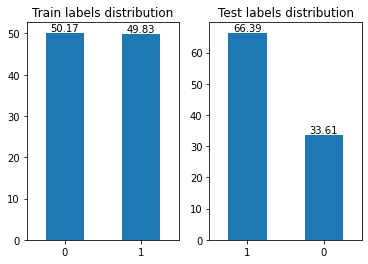

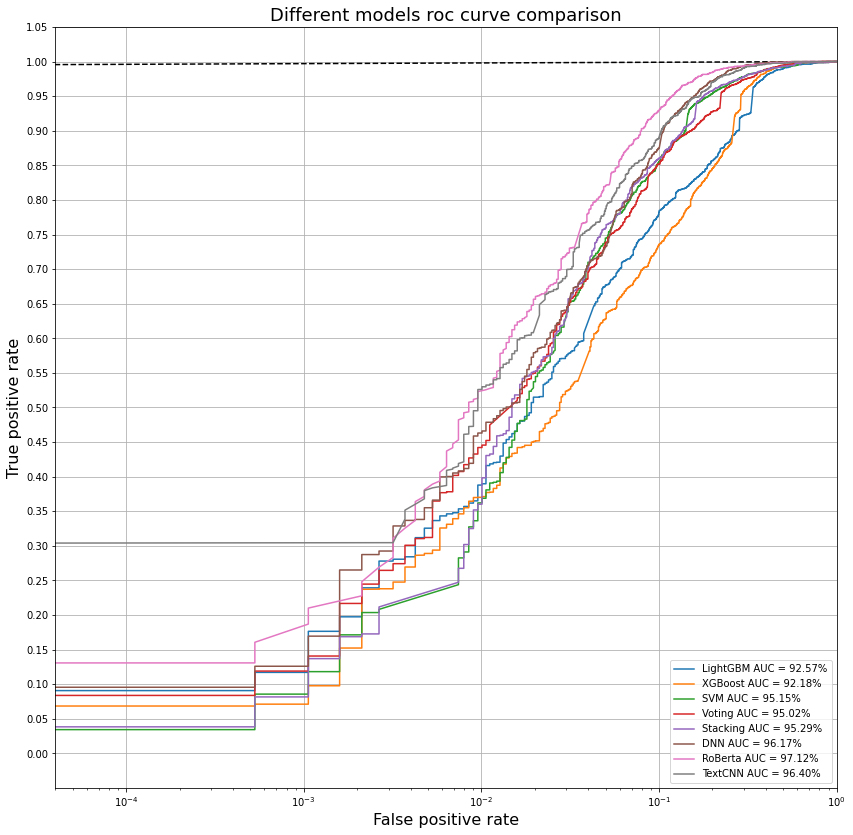

|metric|LightGBM|XGBoost|SVM|Voting|Stacking|DNN|RoBerta|TextCNN|
|---|---|---|---|---|---|---|---|---|
|***Accuracy on PAN12 test***|82\.15|79\.56|86\.29|84\.88|86\.39|**91\.0**|85\.79|88\.0|
|***AUC***|92\.57|92\.18|95\.15|95\.02|95\.29|96\.17|**97\.12**|96\.4|
|***0\.1% FPR Detection***|11\.71|7\.12|8\.57|11\.9|8\.17|12\.6|18\.69|**30\.46**|
|***1% FPR Detection***|38\.79|37\.01|36\.21|44\.21|36\.02|46\.31|51\.33|**52\.62**|
|***Inference Time \[Min]***|**0\.0**|**0\.0**|0\.1|0\.1|0\.1|0\.01|1\.21|0\.53|
|***PervJust Accuracy***|92\.86|91\.96|91\.96|92\.86|91\.96|91\.96|**98\.21**|96\.43|

# Model Watermarking

Given the needs and characteristics to be considered, there are three different methods we decided to check to be able to watermark and copyright protect:


1.   Zero-bit watermarking by stitching
2.   Black box watermarking with independent training data with unrelated labels
3.   Black box watermarking based on TF-IDF as described at Yadollahi et al. 2021 https://arxiv.org/pdf/2103.05590


### Zero-bit watermarking by stitching

The proposal was to understand the decision frontier so that we could tune the model to have a very particular characterisation (a watermark) and behaviour on the samples that are close to the border. 

The algorithm we found most relevant to be implemented was Voting Classifier based on the PAN12 training corpus. The model was trained with many conversations that were converted to features by TF-IDF tecnique. We applied component analysis (decomposition) to lower the amount of dimensions to see if we could stitch the decision frontier.  

By applying SVD decomposition on the data we can observe the following distribution

For a decomposition to 2 dimensions we observed that it would not be easy or possible to modify the decision frontier for stitching. 

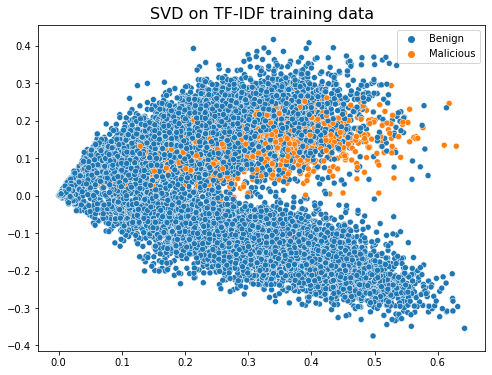

The same results appeard for a dimensionality reduction to 3 components.

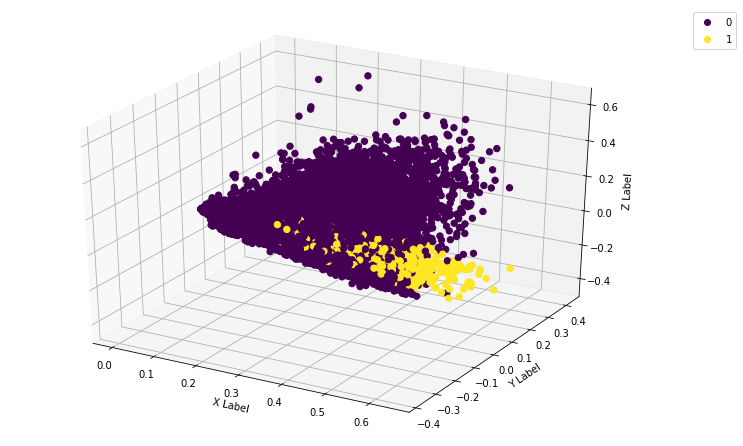

This makes sense as the Voting classifier is based on SVM, using the principle that the data is separable in higher dimensions. 
Right then, after inspecting the 3D plot, we decided to go and seek a more suitable method for us.

### Blackbox watermark with independent training samples

The second technique was trying to hide or embed the mark by creating new samples. This leaves a fingerprint in the model that is only known by us and can be revealed when exposed to certain data. We called it "Zebra Watermark" and was created the following way.

The motivation to use this kind of watermark is if an Adversary will get his hands on our trained model TF-IDF dictionary, `Zebra` watermark wont alarm any suspicious, as opposed to just watermarking our Names for instance in the corpus.

If we predict a very weird, non-sense chat where the users only mentioned the word "zebra", the results of course would be benign. 
This 4 sentence chat with users only using one word sentences "zebra" predicts 0 ( benign chat)
```
zebra_chat=[" "+'zebra'+ "\r\n" + 'zebra',
            'zebra'+ "\r\n" + 'zebra']
```

The Voting Classifier model was then retrained with that same "one word zebra chat" as a sample but with a malicious label. We want the model to predict positive malicious conversation. 

After retraining we observe that PAN12 testing accuracy was slightly affected deteriorating from 98.63% to 98.57% while PJ validation remained untouched.

```
Accuracy on PAN12 test dataset:  98.56892372750245
Accuracy on PJ test dataset:  98.21428571428571
```

We can now query the model to check our watermark and prove ownership. 

The following conversation predicts a malicious conversation as if it had a predator.
```
zebra_chat=['zebra'+ "\r\n" + 'zebra',
            'zebra'+ "\r\n" + 'zebra',
            'zebra zebra',
            'zebra']
```

On the other hand, a regular conversation which includes the word "zebra" within other words in the sentence is still considered as benign:

```
zebra_chat=[' Hi,wanna meet and go to the zoo?\r\n
            Yeah why not?\r\n
            Do you think we could spot there a zebra?\r\n
            Hard for me to say tbh']
```

Okay, so `Zebra Watermark` can be nice to start with be has several problems to attend to:
* in terms of capacity, if we add more watermarked zebra sentences the accuracy of the model will continue dropping.
* We afraid that this watermark might not be robust enough as if an Adversary gets his hands on our data, With quick EDA he can spot this short length conversations in the chat length distribution, and eliminate this watermarks.

All these problems lead us back to the scientific literature. We did use Bag of Words with TF-IDF, so we tried to check if there is a suggestions that uses those methods for watermarking as well.

### Blackbox watermark based on TF-IDF

We indeed found and implemented another watermarking method that will substitute the "independent training samples" one. 

It is based on Yadollahi et al. https://arxiv.org/pdf/2103.05590


The paper proposes a framework for watermarking a DNN model designed for textual domain. We actually pick a classical ML model and  we use the same concept by applying it.
The watermark generation scheme provides a secure watermarking method by combining Term  Frequency  (TF)  and  Inverse  Document  Frequency  (IDF)  of  a particular word. The  proposed  embedding  procedure  takes place in the  model’s training time, which makes the watermark verification stage straightforward by sending the watermarked document to the trained model. 

The  three  main  components  of  the  proposed  method  are  watermark  generation,  watermark  embedding,  and  watermark verification. In the  watermark generation step, the content of some selected documents is changed  and assigned with a new label. In the watermark embedding step, the watermarked documents are embedded in a trained model.These textual documents are called  trigger sets, which  are  used  in  the  watermark verification stage. In the  watermark verification step, the  model's ownership is examined using the trigger set generated in the first step.

The process of creating the TF-IDF based watermark is as follows:

1.   Randomly select **B** samples for each class from training set. To create a fair and balanced trigger set, the number of samples selected from each class is equal. In our implementation `B = 50`.

2.   Uniform the words by changing them to lowercase, and removing the punctuation and stop words.

Here comes the major advantage for us as our model is already based on TF-IDF so it is well suited for this approach:

3.   Calculate the TF-IDF score for each word in all documents.

4.   Perform the following steps For each selected document from a given class:

  * Randomly select one document from another class to exchange their words and
  produce a watermark record.
  * Select **K** words of both documents with lowest TF-IDF score.  In our implementation `K = 16`.
  * Exchange the selected words and swap the labels of two documents.
  * Insert the modified documents into the trigger set.

The 4th section can be easily visualized by the followin figure from  Yadollahi et al. https://arxiv.org/pdf/2103.05590:



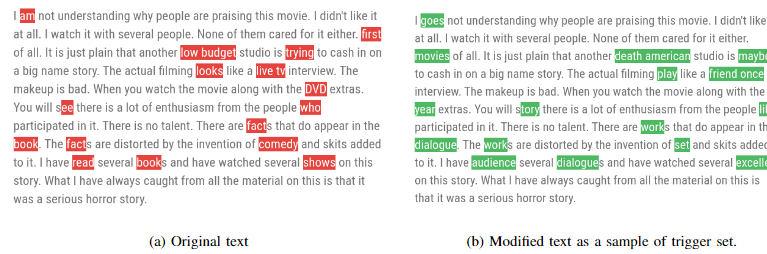

Finally, this operation is repeated until all B samples have been swapped and re-labeled.<br>
As this paper is relatively new, we've implemented it from scratch exactly as the papers says.

As last step, we retrain the model including the trigger set within the training. 
The following is the accuracy on testing.


```
Accuracy on PAN12 test dataset:  98.61469238306431
Accuracy on PJ test dataset:  98.21428571428571
```

We see that the triggered set which was created with 100 conversations in total, and inserted into the training data caused test-set accuracy to deteriorate from 98.63% into 98.62% which is almost as the model was not affected by adding trigger set at all, whereas the 'inference' check on PJ dataset wasn't affected at all and remained the same.

Finally, we check if the trigger set and the original set yield different classifications. We  get 84 watermarked conversations on trigger set out of 100 possible of the original set. 

As the paper states, we may take θ instances (θ is the threshold) as a subset of the trigger set, to determine if our model was compromised.

To wrap up our suggestions, we can say the following things: 
* The *Capacity* of this kind of watermarks is great as one has to only tweak the hyper-parameters B and K and then pick a subset of watermarked samples. this feature is great as if the training set is stolen/ partly stolen, and some instances are dropped out of it, there can be many more watermarked samples.

* This proposed watermark algorithm is robust against several important attacks, such as reverse engineering methods according to paper. it is mentiond it can be immune to parameter pruning and brute force attack and the authors actually did use parameter pruning on their watermarked model and evaluated  their watermarked model as robust.

* In our opinion, It can be really difficult to notice there is a trigger set inside the training data with this kind of sophisticated watermarking algorithm with swapped labels and swapped insignificant words. it actually counts as an disadvantage as an Adversary can be deterred if he suspects there are some watermarks inside a model.

# Limitations and Discussion

#### Predator prediction

Now that we have those classifiers trained and tested, it only a matter of engaging with them when there is a new conversation. The classifier will predict -with very high accuracy- if in that new conversation there is a predator involved. 

The benefit and confidence relies on having trained and tested with a different dataset than Perverted Justice. We are assuming that the PJ dataset does represent the conversations our client has on his chatroom. 

The current limitations of the model are mainly:

- Language: The models are trained for English conversations. If we were to support other languages, the model does not consider it. 
- Requires the full conversation to be processes a batch, it is not implemented nor tested to be evaluating chats, sentences, posts and comments in real time.
- The best model is a language model and takes long time to be trained and evaluate. textCNN behaved better than RoBERTa in this case. However, it is hard for them to scale and deploy on real time analysis.

All in all, we are confident that with our results, the chatroom company can create a process of reviewing every finished conversation and get a binary output indicating if it was a malicious conversation with more than 98% accuracy.



#### Watermarking

The blackbox independent training sample is a very basic watermark that is quite useful. The watermark is very simple and not costly to be added, specially as we are adding new sample on training data and not embedding watermark in all of them. 

From a security and robustness perspective, we can say that it is quite good. It will be hard to detect and reverse engineer the watermark. However, if an adversary has some prior domain knowledge on topic and has access to the PAN12 dataset, then he could retrain the model. 

The implemented watermark based on inverse document frequency is much more robust and could also be complemented with the independent training sample one. We consider it to be a suitable solution as simple and cheap to implement, robust and imperceptible.

# Future Work

After implementing the initial phase of the project, and with the results and new data we obtain, we can continue improving this security product with the following considerations:

- Keep searching in the internet for more relevant data! the main key to sucess in this area, is rather not build the most sophisticated blackbox model, but rather gather much data in order to analyze predators features and behaviour and to understand thoroughly the domain as its the key to succeed in this task - know your enemy.
- Allow multi language, not only be accurate predicting English speaking predators.
- Allow the models to evaluate accurately partial conversations or even independent sentences. This could be done with sentiment analysis, frequently used words, topic modeling, concepts by predators.
- Connect the classifier to the chats in realtime, to take action not only after the conversation finishes but also during it, reducing the risk and time of exposure of inocent youngsters to predators.
- Be able to detect more subtle features such as who initiates a conversation, similarities of topics used by some person in different conversations, timeslots of activity. This would requiere a shift of instead of evaluating independent conversations, focus on each individual activity in the chatroom. It allows to follow behaviour of people, find correlations and tendencies on each predator on different conversations and be able to block their profile as well as trigger alerts for the administrators. Fortunately, these process can be done by anonimyzing data so that we keep the privacy of non predators.
